In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import minimize

# Get data

In [2]:
# On terminal:  conda activate python38

In [3]:
ID = '007'

# Get data
user_folder = 'data/user_' + ID + '/'
df2_cf = pd.read_pickle(user_folder + 'df2_cf.pkl')

# Extract cue data
cue_str = 'Cue_HR'
cue_data = df2_cf[df2_cf['Code']==cue_str] 

# Create a cue trial column
cue_data.insert(0, "CueTrial", list(range(1,len(cue_data)+1)))

# Extract useful data
isHit = cue_data['isHit'].tolist()
fbs = cue_data['FBs'].tolist()
rews = cue_data['rews'].tolist()

# Functions

In [4]:
def get_expected_values(fbs, v0, alpha):
    
    # Initialise vector of values
    vt = np.empty(len(fbs))
    vt.fill(np.nan)

    # Fill in prior
    vt[0] = v0

    # Iterate to fill in vector
    for t in range(1,len(vt)):
    
        # Compute prediction error
        pe = fbs[t-1] - vt[t-1]

        # Compute new vt and fill in 
        vt[t] = vt[t-1] + alpha * pe
    
    return vt

In [5]:
def get_hit_probability(vt, beta):
    
    p_hit =  1 / (1 + np.exp(-beta*vt))
    
    return p_hit

In [6]:
def get_nLL(v0, alpha, beta, fbs, isHit):
    
    # Compute needed stuff
    vt = get_expected_values(fbs, v0, alpha)
    p_hit = get_hit_probability(vt, beta)
    p_nohit =  1 - p_hit

    # likelihood of choices
    l_choice = []
    for ind, hit in enumerate(isHit):
        if hit == 1:
            l_choice.append(p_hit[ind])
        else:
            l_choice.append(p_nohit[ind])
                
    # Compute negative log likelihoods
    nLLs = -np.log(l_choice)
    
    # Total
    nLL = sum(nLLs)

    return nLL, p_hit, vt

# Minimise nLL

In [7]:
# Fixed
beta = 1 # inverse temp

# Free parameters
alpha_values = np.linspace(0.1,1,50)
v0_values = np.linspace(-5,5,50)

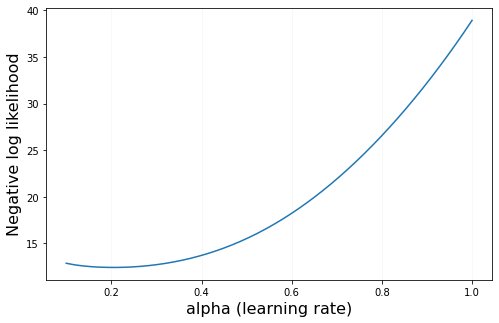

Best alpha is = 0.21020408163265308


In [8]:
# 1d (over alpha)

v0 = 0

# initialise vector of nlls
nLL_values = np.full([len(alpha_values)], np.nan)

# Compute nLL for different alphas
for i, alpha in enumerate(alpha_values):
    nLL, p_hit, vt = get_nLL(v0, alpha, beta, fbs, isHit)
    nLL_values[i] = nLL
    
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(alpha_values, nLL_values)
ax.grid(axis="x", alpha=0.1)
ax.set_xlabel('alpha (learning rate)', fontsize = 16)
ax.set_ylabel('Negative log likelihood', fontsize = 16)
plt.show()

# Extract best parameter
nLL_min = np.amin(nLL_values)
ind_min = np.where(nLL_values == nLL_min)
best_alpha = alpha_values[ind_min]
print('Best alpha is = ' + str(best_alpha[0]))

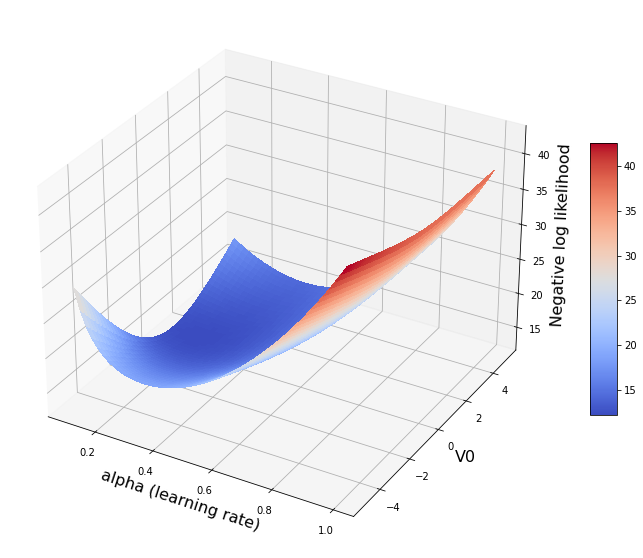

Best alpha is = 0.19183673469387758, best v0 is = 0.7142857142857144


In [9]:
# 2d (over alpha and v0)

# initialise matrix of nlls (+ alphas and v0 for plotting)
mat_nLL = np.full([len(alpha_values), len(v0_values)], np.nan)
mat_alpha = np.full([len(alpha_values), len(v0_values)], np.nan)
mat_v0 = np.full([len(alpha_values), len(v0_values)], np.nan)

# Compute nLL for different alphas and nLLs
for i_alpha, alpha in enumerate(alpha_values):
    for i_v0, v0 in enumerate(v0_values):
        
        nLL, p_hit, vt = get_nLL(v0, alpha, beta, fbs, isHit)
        mat_nLL[i_alpha][i_v0] = nLL
        
        mat_alpha[i_alpha][i_v0] = alpha
        mat_v0[i_alpha][i_v0] = v0


fig, ax = plt.subplots(figsize=(14,10), subplot_kw={"projection": "3d"})

Z = mat_nLL
Y = mat_v0
X = mat_alpha

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

# Labels
ax.set_zlabel('Negative log likelihood', fontsize = 16)
ax.set_ylabel('V0', fontsize = 16)
ax.set_xlabel('alpha (learning rate)', fontsize = 16)

plt.show()

# Extract best parameter
nLL_min = np.amin(mat_nLL)
ind_min = np.where(mat_nLL == nLL_min)
best_alpha = mat_alpha[ind_min]
best_v0 = mat_v0[ind_min]
print('Best alpha is = ' + str(best_alpha[0]) + ', best v0 is = ' + str(best_v0[0]))

# Plot

In [10]:
alpha = 0.192
v0 = 0.714
beta = 1

nLL, p_hit_model, vt_model = get_nLL(v0, alpha, beta, fbs, isHit)

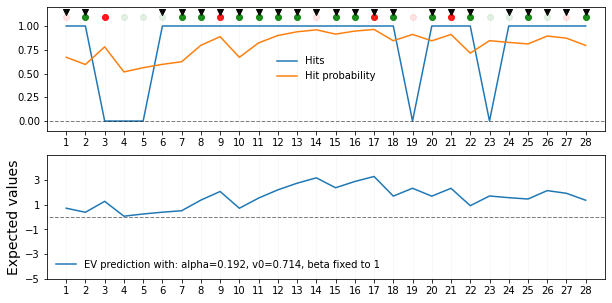

In [29]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,5))


### Subplot 1

# Plot fbs
height_fb = 1.1
x = [ind+1 for ind, el in enumerate(fbs) if el == 5]
l_fb_5 = ax1.scatter(x, height_fb * np.ones(len(x)), c='green', alpha=0.9)
x = [ind+1 for ind, el in enumerate(fbs) if el == 1]
l_fb_1 = ax1.scatter(x, height_fb * np.ones(len(x)), c='green', alpha=0.1)
x = [ind+1 for ind, el in enumerate(fbs) if el == -1]
l_fb_m1 = ax1.scatter(x, height_fb * np.ones(len(x)), c='red', alpha=0.1)
x = [ind+1 for ind, el in enumerate(fbs) if el == -5]
l_fb_m5 = ax1.scatter(x, height_fb * np.ones(len(x)), c='red', alpha=0.9)

# Plot hits (marker)
height_hit = 1.15
x_hit = [ind+1 for ind, el in enumerate(isHit) if el == 1]
l_hits = ax1.scatter(x_hit, height_hit * np.ones(len(x_hit)), c='black', alpha=1, marker='v')

# Plot hits (line)
l_hits_line, = ax1.plot(list(range(1,len(isHit)+1)), isHit)

# Plot probability of hits (from model)
l_p_h_mod, = ax1.plot(list(range(1,len(p_hit_model)+1)), p_hit_model)

# Legend
ax1.legend([l_hits_line, l_p_h_mod], ['Hits', 'Hit probability'], frameon=False)

# Labels etc 
ax1.set_ylim([-0.1,1.2])

### Subplot 2

# Plot expected values (from model)
l_evs, = ax2.plot(list(range(1,len(vt_model)+1)), vt_model)

# Labels etc 
ax2.set_ylim([-5,5])
ax2.set_yticks(np.arange(-5,5,step=2))
ax2.set_ylabel('Expected values', fontsize = 14)

ax2.legend([l_evs], ['EV prediction with: alpha=' + str(alpha)+
                     ', v0='+ str(v0)+', beta fixed to 1'], frameon=False)

### General

# Same characteristics for each ax
for ax in [ax1,ax2]:

    # Plot vertical grid
    ax.grid(axis="x", alpha=0.1)
    
    # Plot horizontal line at 0
    ax.plot(np.arange(-1,30), np.zeros(len(np.arange(-1,30))), 'k--', alpha=0.5, linewidth=1.0)

    # x-axis (trials)
    x_ticks = list(range(1,len(fbs)+1))
    ax.set_xlim(x_ticks[0]-1,x_ticks[-1]+1)
    ax.set_xticks(x_ticks)
    ax.set_xlabel('', fontsize = 18)
    
# Display
plt.show()

In [372]:
# To do trouver le meilleur beta par grid search aussi
# ensuite essayer de trouver un methode d'optimisation style fmincon et voir si trouve les meme valeurs

# Ca c'est juste pour un cue, voir comment faire pour les autres
# probablement otut concatenate? Meme alpha, v0 et beta pour chaque cue ! 
# Mais laisser flexibilite d'avoir un different lerning rate pour pnish cue et reward cue

# ensuite faire pour chaque participant

In [1]:
!pip install scipy

In [6]:
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])

# Nelder-Mead simplex algorithm does not use any gradient evaluations, it may take longer to find the minimum
res = minimize(rosen, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True}) 

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571


In [7]:
print(res.x)

[1. 1. 1. 1. 1.]
